In [237]:
import numpy
import pickle
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import torch
import torch.nn as nn

import pandas as pd

from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader

import matplotlib
matplotlib.rcParams['figure.figsize'] = (9.0, 7.0)
from matplotlib import pyplot

In [2]:
# Load data from numpy file
# debinarizedData = numpy.load('debinarizedData.npy')
# numpy.shape(debinarizedData)

In [3]:
# Load data from pickle file

# infile = open('../Projet/trainDatasetPerdiem-20191028.pkl', 'rb')
# data, labels = pickle.load(infile)

# infile.close()

# data_numpy = data.to_numpy()
# print(labels)
# data.describe() # give column stats

# To one-hot-encode
# - Spécialité de médecins        | 33
# - Université de graduation      | 14
# - Plage horaire de facturation  | 3
# - Agence de représentation      | 845
# - Établissements                | 241

In [4]:
# Separate labeled and unlabeled data

# unlabeled = data_numpy[data_numpy[:, 1182] == -1][:, :-1]
# numpy.random.shuffle(unlabeled)
# numpy.save('unlabeled.npy', unlabeled)

# labeled = data_numpy[data_numpy[:, 1182] != -1]
# numpy.random.shuffle(labeled)
# numpy.save('labeled.npy', labeled)

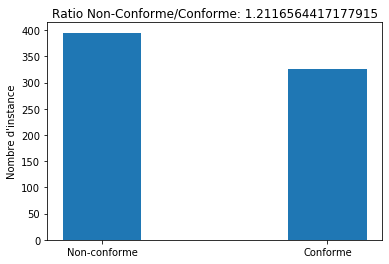

In [204]:
# Make smaller sample for testing

# unlabeled = debinarizedData = numpy.load('unlabeled.npy')
# smaller_size = 5000
# smaller_unlabeled = unlabeled[:smaller_size]
# numpy.save('smaller_unlabeled.npy', smaller_unlabeled)

smaller_unlabeled = numpy.load('smaller_unlabeled.npy')
labeled = numpy.load('labeled.npy')

X, y = labeled[:, :-1], labeled[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert Data to pytorch tensors
X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test_tensor = torch.from_numpy(y_test).float().to(device)

labels = ['Non-conforme', 'Conforme']

numberOfClass0 = len(y_test[y_test == 0])
numberOfClass1 = len(y_test[y_test == 1])
ratio = numberOfClass0/numberOfClass1

x = numpy.arange(len(labels))
width = 0.35

fig, subfig = pyplot.subplots()
subfig.bar(x, [numberOfClass0, numberOfClass1], width)

subfig.set_ylabel('Nombre d\'instance')
subfig.set_title(f'Ratio Non-Conforme/Conforme: {ratio}')
subfig.set_xticks(x)
subfig.set_xticklabels(labels)

pyplot.show()

In [205]:
# Make dataset
class RAMQDatasetForAE(Dataset):
    
    def __init__(self, data):
        super().__init__()
        self.data = []
        for elem in data:
            if isinstance(elem, numpy.ndarray):
                elem = elem.tolist()
            # Convert to pytorch tensor
            elem = torch.Tensor(elem)
            # AE targets are same as inputs -> [x, x']
            self.data += [(elem, elem)]

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)
    

In [506]:
# Clustering model
# Ref tied weights:
# https://discuss.pytorch.org/t/how-to-create-and-train-a-tied-autoencoder/2585/13
# https://gist.github.com/InnovArul/500e0c57e88300651f8005f9bd0d12bc

class Encoder(nn.Module):
    def __init__(self, dimensions, 
                 k_features, 
                 nb_layers=3,
                 activation=nn.ReLU(),
                 init=None,
                ):
        super(Encoder, self).__init__()
        
        self.activation = activation
        self.init = init
        
        # Speed of reduction
        reduction_ratio = (k_features/dimensions)**(1/(nb_layers))
        
        layers = []
        layer_lenght = dimensions
        
        # Calculate nb of layers and nb of neurons
        # Builds a list (ex:[1000, 500, 250, ... until k_features])
        # This list is half the network, aka encoder. Decoder will be
        # built using the inverse list 
        while layer_lenght > k_features:
            layers.append(layer_lenght)
            layer_lenght = int(layer_lenght*reduction_ratio)
        layers.append(k_features)
        
        # Build encoder layers
        encoder_layers = []
        for i, n_neurons in enumerate(layers[:-1]):
            layer = nn.Linear(layers[i], layers[i+1], bias=False)
            if init:
                init(layer.weight)
            encoder_layers.append(layer)
            encoder_layers.append(activation)
            encoder_layers.append(nn.Dropout(0.5))
        
        # Save decoder structure for DecoderFromEncoder()
        self.decoder_layers_sizes = list(reversed(layers))
                                
        # Build pytorch sequential network
        self.encoder = nn.Sequential(
            *encoder_layers
        )
        
        
    def forward(self, x):
        x = self.encoder(x)
        return x
    
class DecoderFromEncoder(nn.Module):
    def __init__(self, encoder):
        super(DecoderFromEncoder, self).__init__()
        
        # Copy encoder hyperparams
        activation = encoder.activation
        
        # Array of decoder layer sizes calculated from encoder
        decoder_layers_sizes = encoder.decoder_layers_sizes
        # Pytorch nn layers of encoder
        encoder_layers = list(encoder.named_parameters())
        
        
        
        # Build decoder layers
        decoder_layers = []
        encoder_layers.reverse()
        for i, n_neurons in enumerate(decoder_layers_sizes[:-1]):
            layer = nn.Linear(decoder_layers_sizes[i], 
                              decoder_layers_sizes[i+1], bias=False)
            # Replace weights with those of encoder
            weights = encoder_layers[i][1].data.transpose(0,1)
            layer.weight.data = weights
            #layer.bias.data = bias
            # Add layer
            decoder_layers.append(layer)
            # Add activation
            decoder_layers.append(activation)
        
        # Build pytorch sequential network
        self.decoder = nn.Sequential(
            *decoder_layers
        )

    def forward(self, x):
        x = self.decoder(x)
        return x


In [507]:
# Test Autoencoder classes
test_Encoder = Encoder(dimensions=1182,
                       k_features=400,
                       nb_layers=4
                      )
test_Decoder = DecoderFromEncoder(test_Encoder)

In [508]:
# AE Training
# Pretrain autoencoder to minimise reconstruction loss 
# and keep model for clustering
def pretrainAutoEncoder(encoder, nb_epoch=1, verbose=True, plot_loss=False, data=smaller_unlabeled):
    # Setup cuda if available
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Training parameters 
    learning_rate = 0.01
    momentum = 0.9
    batch_size = 100     # SGD optimizer
    weight_decay = 1e-5  # Adam optimizer

    # Load data set and create dataloader
    train_set = RAMQDatasetForAE(smaller_unlabeled)

    train_loader = DataLoader(train_set, batch_size=batch_size)

    # Load model and setup proper device
    encoder.to(device)

    # Reconstruction loss and optimzer
    rec_criterion = nn.MSELoss()
    optimizer = SGD(encoder.parameters(), lr=learning_rate, momentum=momentum)
#     optimizer = Adam(encoder.parameters(), weight_decay=weight_decay)

    encoder.train()
    losses = []
    for i_epoch in range(nb_epoch):

        start_time, train_losses = time.time(), []
        for i_batch, batch in enumerate(train_loader):
            # Read batch data
            x, y = batch
            
            # Create decoder from current encoder
            decoder = DecoderFromEncoder(encoder)
            decoder.to(device)
            decoder.train()
            
            # Freeze decoder weights 
            for name, param in decoder.named_parameters():
                param.requires_grad = False
            
            # Reset gradients to zero
            optimizer.zero_grad()

            # Encode-decode
            encoded = encoder(x)
            decoded = decoder(encoded)
            
            # Reconstruction loss
            rec_loss = rec_criterion(decoded, y)
            loss = rec_loss

            # Backpropagate and gradient descent
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        mean_loss = numpy.mean(train_losses)
        losses.append(mean_loss)
        if verbose:
            print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
                i_epoch+1, nb_epoch, mean_loss, time.time()-start_time))
    if plot_loss:
        pyplot.plot(losses)
        pyplot.title('Epoch Losses')
        pyplot.xlabel('Epoch')
        pyplot.ylabel('Loss')
        pyplot.show()

In [510]:
# Linear SVM performance with all dimensions
clf = LinearSVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("Score on all dimensions:", score)

# Input_dimensions length
input_d = numpy.shape(smaller_unlabeled)[1]
k_features = 100
nb_layers = 2

encoder = Encoder(dimensions=input_d,
                    k_features=k_features,
                    nb_layers=nb_layers
                   )

# train on unlabeled data
pretrainAutoEncoder(encoder, nb_epoch=20, verbose=True, plot_loss=False)

# Reduce dimensions on inputs
encoder.eval() 
X_train_reduced = encoder(X_train_tensor).detach().numpy()
X_test_reduced = encoder(X_test_tensor).detach().numpy()

# Train Linear SVM
clf = LinearSVC()
clf.fit(X_train_reduced, y_train)

# Calculate validation performance
score = clf.score(X_test_reduced, y_test)
print(f"Score on {k_features} dimensions:", score)

c:\users\alext\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Score on all dimensions: 0.841886269070735
 [-] epoch    1/20, train loss 0.030796 in 0.96s
 [-] epoch    2/20, train loss 0.030794 in 1.12s
 [-] epoch    3/20, train loss 0.030792 in 0.92s
 [-] epoch    4/20, train loss 0.030790 in 1.00s
 [-] epoch    5/20, train loss 0.030789 in 0.98s
 [-] epoch    6/20, train loss 0.030788 in 0.94s
 [-] epoch    7/20, train loss 0.030786 in 0.98s
 [-] epoch    8/20, train loss 0.030785 in 0.98s
 [-] epoch    9/20, train loss 0.030783 in 0.99s
 [-] epoch   10/20, train loss 0.030781 in 0.98s
 [-] epoch   11/20, train loss 0.030779 in 0.97s
 [-] epoch   12/20, train loss 0.030776 in 0.99s
 [-] epoch   13/20, train loss 0.030774 in 0.98s
 [-] epoch   14/20, train loss 0.030773 in 1.01s
 [-] epoch   15/20, train loss 0.030770 in 1.04s
 [-] epoch   16/20, train loss 0.030769 in 1.00s
 [-] epoch   17/20, train loss 0.030765 in 1.04s
 [-] epoch   18/20, train loss 0.030763 in 1.03s
 [-] epoch   19/20, train loss 0.030758 in 0.99s
 [-] epoch   20/20, train 

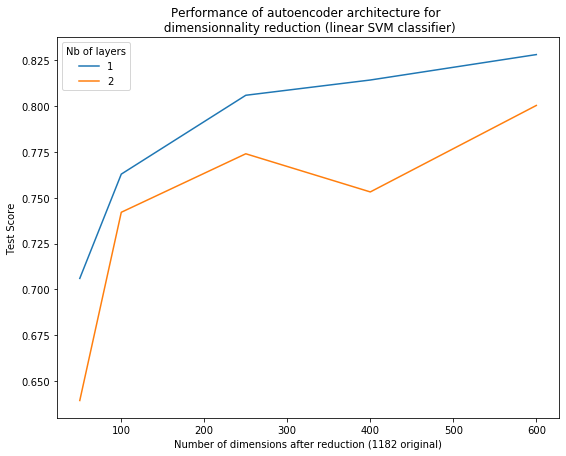

In [512]:
# Test effect of number of k reduced dimensions
# and network depth
start_time = time.time()

# Input_dimensions length
input_d = numpy.shape(smaller_unlabeled)[1]

K = [600, 400, 250, 100, 50]
L = [1, 2]

step = 1/(len(K)*len(L))

for i, l in enumerate(L):
    scores = []
    for j, k in enumerate(K):
        encoder = Encoder(dimensions=input_d, 
                            k_features=k, 
                            nb_layers=l)

        # train on unlabeled data
        pretrainAutoEncoder(encoder, nb_epoch=10, verbose=False)

        
        # Reduce dimensions on inputs
        encoder.eval() 
        X_train_reduced = encoder(X_train_tensor).detach().numpy()
        X_test_reduced = encoder(X_test_tensor).detach().numpy()
        
        # Train Linear SVM
        clf = LinearSVC()
        clf.fit(X_train_reduced, y_train)
        
        # Calculate validation performance
        score = clf.score(X_test_reduced, y_test)
        scores.append(score)
        
        # Display progress
        progress = 100*((step*(i)*len(K))+(step*(j+1)))
        print(f'[ {progress:.0f}% ] {l} layers, {k} features, score: {(100*score):.2f}% | {(time.time()-start_time):.1f}s \t', end='\r')
    
    pyplot.plot(K, scores, label=f'{l}')
    
pyplot.title(f'Performance of autoencoder architecture for \n dimensionnality reduction (linear SVM classifier)')
pyplot.ylabel('Test Score')
pyplot.xlabel(f'Number of dimensions after reduction ({input_d} original)')
pyplot.legend(title="Nb of layers")
pyplot.show()

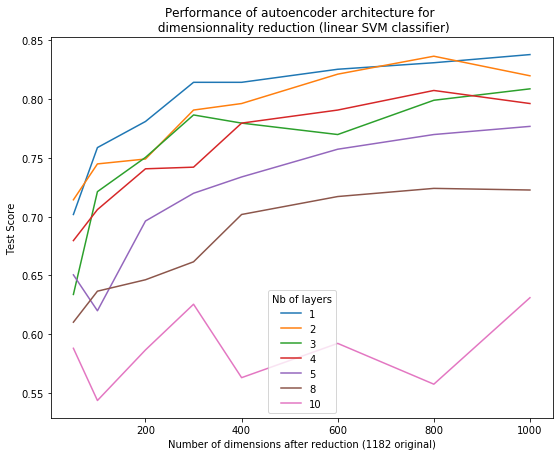

In [413]:
# Test effect of number of k reduced dimensions
# and network depth
start_time = time.time()

# Input_dimensions length
input_d = numpy.shape(smaller_unlabeled)[1]

K = [1000, 800, 600, 400, 300, 200, 100, 50]
L = [1, 2, 3, 4, 5, 8, 10]

step = 1/(len(K)*len(L))

for i, l in enumerate(L):
    scores = []
    for j, k in enumerate(K):
        encoder = Encoder(dimensions=input_d, 
                            k_features=k, 
                            nb_layers=l,
                            activation=nn.LeakyReLU(),
                            init=nn.init.xavier_uniform_
                           )

        # train on unlabeled data
        pretrainAutoEncoder(model, verbose=False)
        
        # Reduce dimensions on inputs
        encoder.eval()
        X_train_reduced = encoder(X_train_tensor).detach().numpy()
        X_test_reduced = encoder(X_test_tensor).detach().numpy()
        
        # Train Linear SVM
        clf = LinearSVC()
        clf.fit(X_train_reduced, y_train)
        
        # Calculate validation performance
        score = clf.score(X_test_reduced, y_test)
        scores.append(score)
        
        # Display progress
        progress = 100*((step*(i)*len(K))+(step*(j+1)))
        print(f'[ {progress:.0f}% ] {l} layers, {k} features, score: {(100*score):.2f}% | {(time.time()-start_time):.1f}s \t', end='\r')
    
    pyplot.plot(K, scores, label=f'{l}')
    
pyplot.title(f'Performance of autoencoder architecture for \n dimensionnality reduction (linear SVM classifier)')
pyplot.ylabel('Test Score')
pyplot.xlabel(f'Number of dimensions after reduction ({input_d} original)')
pyplot.legend(title="Nb of layers")
pyplot.show()

In [ ]:
# AE clustering optimisation
# Must retrain the autoencoder from pretrained weights
# now optimising weights to minimise clustering loss
# AND reconstruction loss
